# 이미지 임베딩을 통해 닮은꼴 찾기

![img](https://jsideas.net/assets/img/20190820.png)

**context**
1. [임베딩은 무엇일까?](#임베딩은-무엇일까)
2. [얼굴임베딩 만들기 - 얼굴인식](#얼굴임베딩-만들기-얼굴인식)
3. [얼굴임베딩 만들기 - FaceNet](#얼굴임베딩-만들기--FaceNet)
4. [얼굴임베딩 사이의 거리측정](#얼굴임베딩-사이의-거리측정)
5. [얼굴임베딩 공간의 시각화](#얼굴임베딩-공간의-시각화)
6. [가장-닮은꼴-얼굴-찾아보기](#가장-닮은꼴-얼굴-찾아보기)



## 임베딩은 무엇일까

오늘 우리가 다루어보고자 하는 *두 얼굴이 얼마나 닮았나* 하는 문제는 컴퓨터에겐 **두 얼굴 벡터 사이의 거리가 얼마나 되나**라는 문제로 치환됩니다. 중요한 것은 바로 두 점 사이의 거리가 실제로 두 오브젝트 사이의 유사도를 정확하게 반영해야 한다는 점입니다.

닮은 얼굴을 찾기 위해서는 찾고자 하는 얼굴이 있는 사진과 비교하고싶은 얼굴이 있는 사진을 비교해야 합니다. 이때 어떤 한 이미지가 가로, 세로가 100pixel, RGB 채널을 사용하고 있다고 가정해봅시다. 이 이미지와 유사한 대상을 찾고싶다고 할 때 단순히 차원값을 계산해보면 가로x세로x채널 = 100x100x3 = 30000차원의 벡터를 비교해야 합니다. 너무 높은 차원수이고, 높은 차원수 사이의 비교는 사실상 무의미해집니다. 그럼 어떻게 이미지의 차원수를 줄일 수 있을까요?

> 임베딩의 등장!

이 문제를 해결하기 위해 등장한 것이 바로 임베딩입니다. 즉, **고차원의 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 것**이 임베딩입니다. 

얼굴 이미지가 저차원으로 변환되고, 이 변환된 벡터에 누군지 알아볼 수 있는 정보가 남는다고 가정하면 임베딩 벡터만으로 얼굴을 비교할 수 있게 됩니다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/E-11-3.jpg)

오늘 다룰 이미지 임베딩 모델은 위 그림처럼 이미지를 128차원의 얼굴 임베딩 벡터로 변환해 줄 것입니다. 본격적으로 시작하기에 앞서, 임베딩의 개념에 대해 잘 정리된 아래 링크의 글을 읽어봅시다.

- [개요: 머신러닝을 위한 특성 임베딩 추출 및 제공](https://cloud.google.com/solutions/machine-learning/overview-extracting-and-serving-feature-embeddings-for-machine-learning?hl=ko)




## 얼굴임베딩 만들기 - 얼굴인식

이미지 속의 두 얼굴이 얼마나 닮았는지 알아보기 위해 얼굴 임베딩을 구할 것입니다. 가장 먼저, **얼굴 영역만을 정확하게 인식해서 추출**해내는 작업을 먼저 해봅시다.

![IMG](https://aiffelstaticprd.blob.core.windows.net/media/images/E-11-2.max-800x600.jpg)

위 사진과 같이 얼굴이 들어있는 input image가 주어지면 얼굴을 detect 하는 과정을 거쳐 얼굴 이미지 영역만을 잘라낼 수 있습니다.

얼굴 인식을 하는 방법에 대해서는 많은 방법이 있지만, 오늘 우리가 사용할 것은 **Face Recognition** 라이브러리입니다. `dlib`라는 널리 쓰이는 Object Detection 패키지로 만들어졌습니다. `dlib`에서는 이미 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM의 sliding window로 얼굴을 찾는 face detector 기능을 제공하고 있습니다.  이미 dlib의 얼굴인식 정확도는 99.38%에 달한다고 합니다.

그렇지만 오늘은 `Face Recognition` 라이브러리를 사용해 보려고 합니다. 아래에 깃허브 레포지토리도 한번 살펴보세요 :)

- [Face Recognitioin Github Repository](https://github.com/ageitgey/face_recognition)



### 라이브러리 설치

이번 시간에 사용할 라이브러리를 설치해줍시다. 참고로, `face_recognition` 설치 작업은 7~8GB 정도의 메모리를 요구할 수 있습니다. 설치 전 시스템의 가용 메모리량을 체크해주세요.

```bash
$ pip install cmake
$ pip install dlib
$ pip install face_recognition --user
```

무사히 설치했으면 샘플 이미지를 다운로드 해줍시다. 샘플 이미지는 `./data/face_embedding` 폴더에 있습니다.

샘플 이미지의 `obama.jpg` 이미지를 불러온 후 얼굴을 `face_recognition.face_locations`를 사용해 찾아줍시다. 그렇게 박스를 찾게되면 임베딩 추출을 할 이미지를 만들기 위해서 잘라줍니다. 시작해봅시다!

얼굴 영역 좌표 :  [(98, 758, 284, 572)]


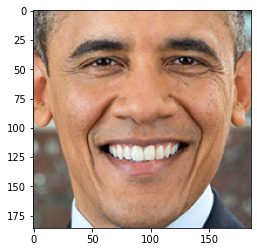

In [1]:
import face_recognition
import os
import matplotlib.pyplot as plt

image_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/face_embedding/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print("얼굴 영역 좌표 : ", face_locations)

a, b, c, d = face_locations[0]
cropped_face = image[a:c, d:b, :]

plt.imshow(cropped_face)
plt.show()

잘 출력되네요!

우리는 5명의 대통령 사진을 `./data/face_embedding` 폴더에 넣어두었습니다. 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수를 하나 만들어줍시다.

In [2]:
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c, d:b, :]
    return cropped_face

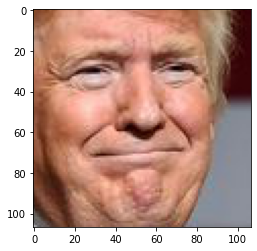

In [3]:
# 한번 확인해봅시다!
image_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/face_embedding/trump.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

## 얼굴임베딩 만들기 - FaceNet

![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/E-11-4.png)

얼굴의 특징을 추출하고 적은 차원의 벡터로 만들기 위해서 우리는 딥러닝을 사용합니다. 그렇다면 딥러닝 모델이 어떻게 얼굴의 특징을 잘 비교할 수 있는 모델이 되도록 학습시킬 수 있을까요?

2015년 구글에서 발표한 **FaceNet**이 있습니다. FaceNet은 우리가 봐왔던 딥러닝 모델과 크게 다르지 않지만 네트워크 뒤에 *L2 Normalization*을 거쳐 임베딩을 만들어내고 여기에 *Triplet Loss*를 사용하고 있습니다. 

**L2 Normalization**은 모델 결과물의 L2 distance를 구한 후에 이것으로 결과물을 나누어주어 Normalization을 해주는 과정입니다. 이렇게 L2 Normalization 레이어를 거쳐 나온 임베딩 벡터는 벡터의 크기가 1로 맞추어질 것이므로, 128차원의 공간상에 반지름이 1인 구가 있다고 할 때, 구의 표면상의 한 점을 가리키는 벡터처럼 분포될 것입니다. 이렇게 제약조건을 두면 이후 두 점 사이의 거리를 계산할 때 두 벡터의 절대적 크기에 무관하게 두 벡터 사이의 *각도에만* 영향을 받게될 것입니다.

**Triplet Loss**는 그럼 무엇일까요? 아래 사진을 한번 봐봅시다.

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/E-11-5.max-800x600.png)

**Triplet Loss**는 이름에서 볼 수 있듯이, `Anchor`, `Negative`, `Positive` 세개의 데이터 쌍을 이용해 계산하는 손실함수로, 네트워크를 학습시킬 수 있습니다.

시작할 때 임베딩 벡터 안에 보존되어야 할 정보는 **A는 B에 비해 C에 더 가깝다**라는 상대적인 비교수치밖에 없습니다. Triplet Loss의 개념은 정확하게 이 아이디어를 반영하고 있습니다. 사람 얼굴 데이터셋에서 A와 C는 같은 사람의 얼굴 사진에서 나온 임베딩 벡터, B는 다른 사람 얼굴 사진에서 만들어진 임베딩 벡터가 되도록 데이터셋을 구성합니다. 그렇다면 정확히 *A는 B에 비해 C에 더 가깝다* 라는 논리가 성립하게 됩니다.

Triplet Loss는 같은 사람은 임베딩 벡터 **A-C**간의 거리를 가깝게, 그리고 다른 사람의 임베딩 벡터 **B-C**간의 거리는 멀게 학습시키는 효과를 가져옵니다. 

아직 잘 감이 안잡히신다고요? 그렇다면 아래 글을 읽어보고 옵시다!

- [Andrew Ng 교수님의 Triplet Loss 영상](https://aiffelstaticprd.blob.core.windows.net/media/images/E-11-5.max-800x600.png)
- [FaceNet: A Unified Embedding for Face Recognition and Clustering 논문](https://arxiv.org/abs/1503.03832)

### FaceNet을 이용해 얼굴 임베딩을 해봅시다!

Face Recognition 라이브러리에는 바로 위에 소개한 `FaceNet` 얼굴 임베딩 모델이 탑재되어 있습니다. 이 모델을 이용해서 우리가 다운받아둔 5장의 이미지에서 얼굴 임베딩을 추출해 봅시다.


In [4]:
dir_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/face_embedding'
file_list = os.listdir(dir_path)

print("file list : {}".format(file_list))

file list : ['clinton.jpeg', 'trump.jpg', 'biden.jpg', 'bush.jpeg', 'obama.jpg']


`obama.jpg`에 포함된 얼굴 영역의 임베딩 벡터를 구해봅시다. 이전 스텝에서 이미지 파일의 얼굴 영역을 가져오는 get_cropped_face() 함수를 활용해 얼굴 임베딩을 구해봅시다!

In [5]:
image_file = os.path.join(dir_path, 'obama.jpg')
face = get_cropped_face(image_file)

# 얼굴 영역을 가지고 얼굴 임베딩을 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)
embedding

[array([-0.08126248,  0.11014761, -0.01082448, -0.05268792,  0.01033717,
        -0.00813808, -0.07251769, -0.0922646 ,  0.19304723, -0.09246384,
         0.23908533,  0.06770287, -0.22123125, -0.14119367,  0.05562152,
         0.13705511, -0.17924425, -0.07232306, -0.11183281, -0.11370818,
         0.03956435, -0.01019115,  0.0942178 ,  0.04493114, -0.12757549,
        -0.34449592, -0.05374938, -0.17703305,  0.00868226, -0.09721592,
        -0.09817187,  0.00278232, -0.17721367, -0.12789807,  0.03489833,
        -0.01991234, -0.00838933, -0.00132862,  0.18308581,  0.02447568,
        -0.1237656 ,  0.09957044,  0.02323568,  0.22983313,  0.2838524 ,
         0.06655717, -0.00558912, -0.09833544,  0.10058986, -0.23476946,
         0.06006292,  0.1341591 ,  0.08373027,  0.03900504,  0.10194533,
        -0.19337648,  0.01717628,  0.08978969, -0.16005114,  0.01892098,
         0.03082444, -0.06051281, -0.04526773,  0.04633342,  0.20678686,
         0.10299795, -0.12437531, -0.0490516 ,  0.1

좋습니다. 128차원의 임베딩 벡터가 만들어졌습니다.

그럼 이제 images 디렉토리 안에 있는 모든 이미지 파일의 임베딩을 구해서 `dict` 구조에 담아 리턴하는 함수를 만들어봅시다. 딕셔너리의 각 앨리먼트는 `사람이름:임베딩벡터`로 합시다.

In [6]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        image_path = os.path.join(dir_path, file)
        face = get_cropped_face(image_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
    
    return embedding_dict

그럼 이미지들을 `embedding_dict`에 넣고 잘 만들었는지 하나만 출력해봅시다!

In [7]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
        0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
        0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
        0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
       -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
       -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
        0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
        0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
       -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
       -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
       -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
       -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
        0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
        0.05921567, -0.06115703, -0.11171092,  0.23917492, -0.15

잘 들어갔군요! :)


## 얼굴임베딩 사이의 거리측정

임베딩 공간속에서 임베딩 벡터들의 거리가 어떤 의미인지 다시 생각해봅시다. 

Triplet Loss는 앞에서 말한바와 같이 같은 사람의 얼굴 쌍을 임베딩 공간 상에서 가깝도록, 글고 다른 사람의 얼굴 쌍을 멀도록 학습시킵니다. 즉, 이를 이용해 학습된 모델에서는 임베딩 공간에서 서로 다른 사람의 얼굴 임베딩 거리가 멀게 표현되어 있습니다.

|A|B|C|
|:---:|:---:|:---:|
|![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/e-11-new1.png)|![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/e-11-new2.png)|![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/e-11-new3.png)|

위의 세 사람의 이미지를 Face Detection 모델로 미리 잘랐습니다. 그리고 이전 스텝에서 용했던 모델을 사용해서 128차원의 임베딩 벡터를 추출했습니다. 순서대로 왼쪽부터 A, B, C에 각각 임베딩 벡터값을 넣어두었습니다. 물론 B와 C가 같은 사람이라는 것을 쉽게 알아보실 겁니다. 그렇다면 모델도 정말 구분하도록 학습을 통해 임베딩 간의 거리가 확보됐는지 확인해 보도록 하겠습니다.

In [8]:
import numpy as np

A = np.array([0.0019173615146428347, 0.17689529061317444, 0.0763588473200798, -0.024574430659413338, -0.13141091167926788, 0.0344821996986866, -0.0374063216149807, -0.07056370377540588, 0.048655178397893906, -0.03414120525121689, 0.22696012258529663, -0.061402369290590286, -0.24329672753810883, -0.039421431720256805, 0.0621466189622879, 0.1220191940665245, -0.1616966724395752, -0.06176016479730606, -0.18894734978675842, -0.06051916256546974, -0.010404378175735474, -0.05918719246983528, 0.02205268107354641, -0.06932859122753143, -0.20260301232337952, -0.2425234317779541, -0.04454419016838074, -0.11400106549263, -0.02022719383239746, -0.15134216845035553, 0.07622595876455307, -0.0323314443230629, -0.1404413878917694, -0.056338660418987274, -0.04520038887858391, -0.026131991297006607, -0.0352761372923851, -0.0679447203874588, 0.1318240910768509, 0.034210119396448135, -0.17475582659244537, 0.13853909075260162, -0.0027398746460676193, 0.227312833070755, 0.3029572069644928, 0.004932125099003315, 0.05853061378002167, -0.07521739602088928, 0.1443275809288025, -0.2340908795595169, 0.030092637985944748, 0.040133409202098846, 0.1672351360321045, 0.05728958174586296, 0.11475440859794617, -0.07548368722200394, 0.040267568081617355, 0.16487033665180206, -0.21067440509796143, 0.036163005977869034, 0.051559075713157654, -0.05994952470064163, 0.029524143785238266, -0.04122130945324898, 0.13074155151844025, 0.1142958477139473, -0.00561982998624444, -0.09740489721298218, 0.18533651530742645, -0.10422169417142868, -0.11409182846546173, 0.02283927984535694, -0.08339140564203262, -0.13673236966133118, -0.3275497853755951, -0.0002689119428396225, 0.2842463254928589, 0.13883619010448456, -0.29149484634399414, -0.07276060432195663, -0.03179163485765457, 0.011192545294761658, 0.03802505508065224, 0.03392524644732475, -0.03972085565328598, -0.12013585865497589, -0.06272879987955093, -0.026893358677625656, 0.2430601865053177, -0.12022019177675247, -0.010466678068041801, 0.20199882984161377, 0.051095910370349884, -0.13243277370929718, 0.06056740880012512, -0.04802423343062401, -0.12318279594182968, -0.013157366774976254, -0.12076889723539352, -0.07183175534009933, -0.01982908323407173, -0.15032584965229034, -0.026652328670024872, 0.06820419430732727, -0.24668177962303162, 0.1818322390317917, -0.01959969662129879, -0.07208395004272461, -0.0680316612124443, -0.038368165493011475, 0.021410271525382996, 0.06388168036937714, 0.2293335199356079, -0.22541724145412445, 0.19133104383945465, 0.24343697726726532, -0.04034627974033356, 0.07534503191709518, 0.017645064741373062, 0.054646339267492294, -0.046512290835380554, 0.07076910138130188, -0.0960201621055603, -0.12610889971256256, -0.017934376373887062, -0.010262779891490936, 0.01885927841067314, 0.057148948311805725])

B = np.array([-0.08116298168897629, 0.1283080279827118, 0.024102725088596344, -0.03748808428645134, 0.06578215956687927, -0.07137967646121979, -0.10578329861164093, -0.0911930501461029, 0.19589228928089142, -0.09603863954544067, 0.2447616308927536, 0.07736924290657043, -0.17048686742782593, -0.1277867704629898, 0.06390697509050369, 0.12272421270608902, -0.19242052733898163, -0.08341517299413681, -0.11065894365310669, -0.09501136839389801, -0.010332206264138222, -0.008188878186047077, 0.08251037448644638, 0.04358505830168724, -0.1455313265323639, -0.3595622479915619, -0.07877802848815918, -0.18927346169948578, -0.0018955999985337257, -0.06280332803726196, -0.06073163449764252, 0.03181075677275658, -0.15109844505786896, -0.08682074397802353, 0.017340943217277527, -0.020879391580820084, 0.008258359506726265, 0.016738882288336754, 0.16803768277168274, 0.039162665605545044, -0.09613757580518723, 0.06231086328625679, 0.00924085732549429, 0.2418847680091858, 0.26051488518714905, 0.07355985790491104, 0.05239278823137283, -0.08052310347557068, 0.08884726464748383, -0.24261267483234406, 0.05618546903133392, 0.12175332009792328, 0.09056758135557175, 0.04266638681292534, 0.16591356694698334, -0.2005864679813385, 0.01018378883600235, 0.08819808065891266, -0.15550008416175842, 0.0815843716263771, 0.03018287755548954, -0.025435002520680428, -0.06714558601379395, 0.009693139232695103, 0.22243273258209229, 0.13470745086669922, -0.1363328993320465, 0.01635543815791607, 0.18212205171585083, -0.03392908349633217, 0.0398673489689827, 0.0043264636769890785, -0.15493592619895935, -0.2530894875526428, -0.23155181109905243, 0.0678660124540329, 0.31580865383148193, 0.21846994757652283, -0.20842058956623077, 0.012199334800243378, -0.12194785475730896, 0.059383176267147064, 0.0768171101808548, -0.012840969488024712, -0.11975857615470886, -0.11892750859260559, -0.03087366186082363, 0.04432998597621918, 0.09186872839927673, 0.0821407362818718, -0.018520792946219444, 0.1962793618440628, -0.0566205158829689, 0.026071354746818542, 0.007139421068131924, 0.02185123600065708, -0.11292634904384613, -0.044381096959114075, -0.18024618923664093, -0.007845945656299591, 0.010368190705776215, -0.07480168342590332, -0.0035089245066046715, 0.09972234815359116, -0.18773995339870453, 0.0474785715341568, 0.025760797783732414, -0.042169712483882904, 0.0014017894864082336, 0.1201503798365593, -0.05088714882731438, -0.02051539719104767, 0.0884844958782196, -0.2176845818758011, 0.25695914030075073, 0.23358485102653503, 0.019985560327768326, 0.17838242650032043, 0.029055196791887283, 0.04518195986747742, -0.044122979044914246, -0.043431997299194336, -0.15906637907028198, -0.07155231386423111, 0.02525237947702408, 0.02502967044711113, 0.04127159342169762, 0.011846683919429779])

C = np.array([-0.0762145072221756, 0.09951083362102509, 0.0012626983225345612, -0.05529194697737694, -0.006535547785460949, -0.012212716042995453, -0.07667708396911621, -0.07388101518154144, 0.18756520748138428, -0.07589773088693619, 0.2424328476190567, 0.06438330560922623, -0.22197730839252472, -0.13409815728664398, 0.046808283776044846, 0.14692817628383636, -0.1844339370727539, -0.051137253642082214, -0.1149090975522995, -0.1297808736562729, 0.040612753480672836, -0.002555673476308584, 0.10426937788724899, 0.026295233517885208, -0.13127824664115906, -0.35947439074516296, -0.048153407871723175, -0.17165206372737885, -0.0002263905480504036, -0.10254599899053574, -0.08338439464569092, 0.014203382655978203, -0.18179851770401, -0.13200539350509644, 0.03813670203089714, -0.012789442203938961, -0.0030085663311183453, -0.007307708729058504, 0.17558619379997253, 0.025768719613552094, -0.12877899408340454, 0.11051110923290253, 0.03616628795862198, 0.22539083659648895, 0.2838597595691681, 0.07483825087547302, -0.0036694444715976715, -0.09967216849327087, 0.11106447875499725, -0.22961333394050598, 0.06397823244333267, 0.12394970655441284, 0.06568531692028046, 0.037825535982847214, 0.09586739540100098, -0.18721607327461243, 0.01674063131213188, 0.10057111084461212, -0.15766742825508118, 0.008397659286856651, 0.039109550416469574, -0.06041106954216957, -0.046033550053834915, 0.031240269541740417, 0.2121172845363617, 0.103468157351017, -0.1224282756447792, -0.05559460073709488, 0.12153220176696777, -0.018480442464351654, 0.039875734597444534, 0.007489997893571854, -0.18950346112251282, -0.20904967188835144, -0.23732705414295197, 0.0895664244890213, 0.3778454661369324, 0.16606193780899048, -0.20442475378513336, 0.018602905794978142, -0.18367978930473328, 0.04945264756679535, 0.08889186382293701, 0.002995049115270376, -0.06196683272719383, -0.13028381764888763, -0.03548961132764816, 0.053789377212524414, 0.08386979252099991, 0.016627438366413116, -0.040179431438446045, 0.2289249151945114, -0.02149147540330887, 0.05046383664011955, 0.02314644865691662, 0.05424635857343674, -0.1627081036567688, -0.01140156015753746, -0.18031321465969086, -0.06785157322883606, 0.03336677327752113, -0.06467186659574509, 0.0466950424015522, 0.12832939624786377, -0.2377130389213562, 0.06774994730949402, 0.013810726813971996, -0.019034255295991898, 0.04477768391370773, 0.0660984218120575, -0.031004268676042557, -0.03275192156434059, 0.06632497161626816, -0.24120087921619415, 0.2647172510623932, 0.2477877289056778, 0.054315339773893356, 0.17328208684921265, 0.06950142979621887, 0.019016757607460022, -0.01211759727448225, -0.014044362120330334, -0.17701464891433716, -0.03347969055175781, 0.04914966598153114, 0.05660251900553703, 0.0644666999578476, 0.012375651858747005])

print("슝=3")

슝=3


![img](https://aiffelstaticprd.blob.core.windows.net/media/original_images/E-11-9.png)

각 128차원의 벡터는 넘파이(Numpy)로 연산을 하기위해서 리스트(list)에서 넘파이 배열(Numpy Array)로 변환해 줍니다. 그리고 각 벡터간의 거리를 `numpy.linalg.norm`를 활용하여 L2 Norm Distance로 계산합니다. L2 Norm Distance는 위의 식처럼 각 차원의 차이를 제곱한 뒤 합한 후 제곱근을 구한 값입니다. 2차원 유클리디안 거리를 다차원으로 확장시킨 것이라고 이해하시면 됩니다. 직접 계산해보겠습니다.

In [9]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=2)
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 0.8211549091846528
Distance between B and C: 0.34743558135053815


위 계산 결과에서 볼 수 있듯이 같은 사람인 B와 C의 거리는 0.3474로 다른 사람간의 거리인 0.8212보다 상대적으로 작은 것을 볼 수 있습니다. 이렇게 임베딩으로 사람 얼굴을 비교하고 누가 같은 사람인지를 비교할 수 있다면 임베딩 벡터의 거리가 가까운 얼굴일수록 닮았다고 볼 수 있을 것입니다. 비교할 사진이 더 많으면 신빙성이 더 높아지겠죠?

이제는 두 임베딩 벡터간의 거리를 계산하는 함수를 구현해 봅시다. np.linalg.norm를 활용하면 쉽게 구할 수 있습니다.

우리가 만들 함수는 인자로 파일명의 사람 이름 2개를 받아서, 두 사람의 얼굴 임베딩 사이의 거리(L2 distance)를 구하는 형태입니다.

In [10]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.8885117374787042

## 얼굴임베딩 공간의 시각화

임베딩 벡터를 직접 넘파이 배열로 보니 벡터들이 어떻게 가깝고 먼지 감이 잘 오지 않습니다. 그리고 128차원의 벡터를 우리가 눈으로 볼 수 있도록 시각화를 할수도 없습니다.

고차원 데이터를 저차원으로 바꾼 임베딩처럼 이런 다차원 벡터를 시각화하기 위해서 차원축소를 하는 방법들이 있습니다. 예를 들어 **PCA, T-SNE** 등이 있습니다. 그럼 임베딩을 시각화하면 어떤 식으로 배치가 되는지 확인해보겠습니다. TensorFlow의 Projector는 고차원 벡터를 차원 축소 기법을 사용해서 눈으로 확인할 수 있게 해줍니다. 아래 링크에서 어떤식으로 우리 눈으로 볼 수 있는지, 그리고 같은 사람끼리는 어떤 식으로 배치되는지 직접 확인해봅시다.

- [128D FaceNet LFW Embedding Visualization](https://huyhoang17.github.io/128D-Facenet-LFW-Embedding-Visualisation/)

![Img](https://aiffelstaticprd.blob.core.windows.net/media/images/E-11-10.max-800x600.png)

**PCA** 와 **T-SNE** 를 이용해 우리가 쉽게 볼 수 있는 형태로 차원을 축소할 수 있었습니다. 조금 더 자세히 알아볼까요?

- 먼저 **PCA** 는 주성분 분석이라는 방법으로 Principal Component Analysys 의 준말입니다. 이 방법은 모든 차원의 축에 따른 값의 변화도인 분산(Variance)를 확인한 뒤 그 중 변화가 가장 큰 주요한 축을 남기는 방법입니다.
- **T-SNE** 는 고차원 상에서 먼 거리를 저차원 상에서도 멀리 배치되도록 차원을 축소하는 방식입니다. 먼저 random하게 목표하는 차원에 데이터들을 배치한 후 각 데이터들을 고차원 상에서의 배치와 비교를 하면서 위치를 변경해 주는 알고리즘으로 이해하시면 됩니다.

위의 시각화에서 보듯이 PCA에서는 모든 차원이 잘 반영되지 않는 반면 T-SNE는 Iteration을 거칠 수록 가까운 벡터들이 잘 군집한 형태로 차원 축소가 되는 것을 볼 수 있습니다. 자세한 내용은 아래 참고자료를 확인해 보세요.

- PCA : [차원 감소와 PCA 분석](https://bcho.tistory.com/1209?category=555440)
- T-SNE : [(영상) StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)

## 가장 닮은꼴 얼굴 찾아보기

이전 스텝에서 우리는 다음 기능을 함수로 구현해 보았습니다.

- `def get_cropped_face(image_file)` : 이미지 파일에서 얼굴 영역을 가져오는 함수
- `def get_face_embedding(face)` : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- `def get_face_embedding_dict(dir_path)` : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
- `def get_distance(name1, name2)` : 두 이미지(사람이름) 사이의 임베딩 벡터 거리를 구하는 함수

이제 필요한 정보를 다 가지고 있으므로, 이제는 특정 이미지와 가장 닮은 이미지를 구해보는 기능을 만들 수 있을 것입니다.

우리가 만들고 싶은 함수는 다음과 같이 쓸 수 있기를 바랍니다. `name` 인자에 특정 사람 이름을 주면 그 사람과 가장 닮은 다른 이미지와 거리 정보를 가장 가까운 순으로 정렬해서 표시해 주어야 합니다.



In [11]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('trump')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.

우리는 이미 모든 이미지 파일에 대한 얼굴 임베딩 딕셔너리를 가지고 있습니다.
이제 우리는 이 딕셔너리를 오름차순 정렬하되, 정렬 기준을 바로 trump와의 임베딩 벡터 거리 함수로 할 것입니다. 이때 lambda 함수가 정렬 key로 활용됩니다.

In [12]:
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

[('trump',
  array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
          0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
          0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
          0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
         -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
         -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
          0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
          0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
         -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
         -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
         -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
         -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
          0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
          0.05921567, -0.06

이제 거의 다 왔습니다. 이제 우리는 'trump'에 대해서가 아니라, 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 적절히 출력해 주기만 합니다. 우리가 목표로 하던 함수를 직접 구현해 봅시다.

In [13]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [16]:
# obama와 가장 닮은 사람은 누굴까요?
get_nearest_face('obama', len(embedding_dict)-1)

순위 1 : 이름(biden), 거리(0.846720652777963)
순위 2 : 이름(bush), 거리(0.8628473227070342)
순위 3 : 이름(trump), 거리(0.8885117374787042)
순위 4 : 이름(clinton), 거리(0.9000994624487408)


아주 잘 출력되네요! :)

수고하셨습니다! 다음에는 내 얼굴로도 한번 도전해봅시다!

In [17]:
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:90% !important;}</style>"))